In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras-multi-head
!pip install keras-self-attention

  Created wheel for keras-multi-head: filename=keras_multi_head-0.27.0-cp36-none-any.whl size=15612 sha256=497d9e32a3c445868b65c1c07225b764d66f8188aef8623d27841870bb5e8953
  Stored in directory: /root/.cache/pip/wheels/b5/b4/49/0a0c27dcb93c13af02fea254ff51d1a43a924dd4e5b7a7164d
  Created wheel for keras-self-attention: filename=keras_self_attention-0.46.0-cp36-none-any.whl size=17278 sha256=6414c87c7ea980fa623cb63ee87fa14e1240c6e5c48319eaf1bbdef1cd765ab5
  Stored in directory: /root/.cache/pip/wheels/d2/2e/80/fec4c05eb23c8e13b790e26d207d6e0ffe8013fad8c6bdd4d2
Successfully built keras-multi-head keras-self-attention


In [3]:
import keras
from keras_multi_head import MultiHead
from keras_self_attention import SeqSelfAttention

import numpy as np
import os
import sys

import wave
import copy
import math

import keras

from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation
from keras.layers import GRU, LSTM, Input, Flatten, Concatenate, Embedding, Convolution1D, Dropout, Bidirectional, Conv2D, MaxPooling2D, Conv1D
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import label_binarize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelBinarizer




import tensorflow as tf
#from model import AttentionResNet
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0],True)

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/PROJECT/codes

In [5]:
from features import *
from helper import *

In [6]:
code_path = "/content/drive/MyDrive/Colab Notebooks/PROJECT/data"
emotions_used = np.array(['ang', 'exc', 'neu', 'sad'])
data_path = code_path + "/"
sessions = ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']
framerate = 16000

In [7]:
import pickle
with open(data_path + '/'+'data_collected.pickle', 'rb') as handle:
    data2 = pickle.load(handle)

In [8]:
mocap_hand = []

for ses_mod in data2:
    x_hand = ses_mod['mocap_hand']
    if(x_hand.shape != (200,18)):
        x_hand = np.zeros((200,18))  
    x_hand[np.isnan(x_hand)]=0
    mocap_hand.append( x_hand )
    
mocap_hand = np.array(mocap_hand)
mocap_hand.shape

(4936, 200, 18)

In [9]:
Y=[]
for ses_mod in data2:
    Y.append(ses_mod['emotion'])
    
Y = label_binarize(Y,emotions_used)

Y.shape

(4936, 4)

In [10]:
counter = 0
for ses_mod in data2:
    if (ses_mod['id'][:5]=="Ses05"):
        break
    counter+=1
counter

3838

In [11]:
xtrain_mocap_hand = mocap_hand[:3838]
xtest_mocap_hand = mocap_hand[3838:]
ytrain_mocap_hand = Y[:3838]
ytest_mocap_hand = Y[3838:]

print(xtrain_mocap_hand.shape)
print(xtest_mocap_hand.shape)

print(ytrain_mocap_hand.shape)
print(xtest_mocap_hand.shape)

(3838, 200, 18)
(1098, 200, 18)
(3838, 4)
(1098, 200, 18)


#**MOCAP HAND 1**

In [12]:
def gru_model_hand1():
    model = Sequential()
    model.add(GRU(512, activation='relu', return_sequences=True, input_shape=(200, 18)))
    model.add(GRU(256, activation='relu', return_sequences=True))
    model.add(GRU(128, activation='relu', return_sequences=False))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

    return model

In [13]:
model = gru_model_hand1()
model.summary()

hist = model.fit(xtrain_mocap_hand, ytrain_mocap_hand, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_hand, ytest_mocap_hand))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 200, 512)          817152    
_________________________________________________________________
gru_1 (GRU)                  (None, 200, 256)          591360    
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               148224    
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0

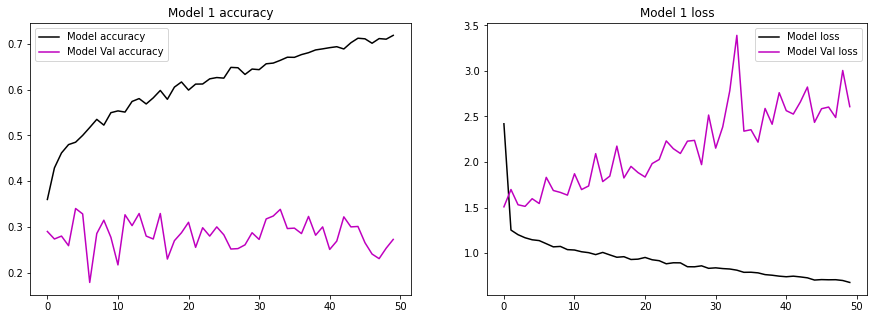

In [14]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [15]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [16]:
loss, acc = model.evaluate(xtrain_mocap_hand, ytrain_mocap_hand,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_hand, ytest_mocap_hand,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.86070 dan Training Accuracy 65.53%
Validation Loss 2.60722 dan Validation Accuracy 27.32%


In [17]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_hand)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_hand, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.72      0.62      0.67       933
         exc       0.84      0.43      0.57       742
         neu       0.73      0.61      0.66      1324
         sad       0.63      0.59      0.61       839

   micro avg       0.72      0.57      0.64      3838
   macro avg       0.73      0.56      0.63      3838
weighted avg       0.73      0.57      0.63      3838
 samples avg       0.57      0.57      0.57      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_hand)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_hand, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.19      0.22      0.20       170
         exc       0.29      0.06      0.10       299
         neu       0.34      0.46      0.39       384
         sad       0.19      0.02      0.04       245

   micro avg       0.29      0.22      0.25      1098
   macro avg       0.25      0.19      0.19      1098
weighted avg       0.27      0.22      0.21      1098
 samples avg       0.22      0.22      0.22      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


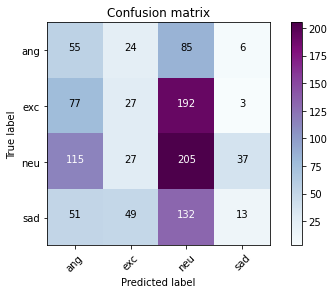

In [20]:
import itertools
Y_pred = model.predict(xtest_mocap_hand)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_hand,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**MODEL_HAND 2**

In [21]:
def gru_model_hand2():
  model = Sequential()
  model.add(GRU(512, return_sequences=True, input_shape=(200, 18)))
  model.add(SeqSelfAttention(attention_activation='relu'))
  model.add(GRU(256, activation='relu', return_sequences=True))
  model.add(SeqSelfAttention(attention_activation='relu'))
  model.add(GRU(128, activation='relu', return_sequences=False))
 

  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dense(4))
  model.add(Activation('softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

  return model

In [22]:
model = gru_model_hand2()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 200, 512)          817152    
_________________________________________________________________
seq_self_attention (SeqSelfA (None, None, 512)         32833     
_________________________________________________________________
gru_4 (GRU)                  (None, None, 256)         591360    
_________________________________________________________________
seq_self_attention_1 (SeqSel (None, None, 256)         16449     
_________________________________________________________________
gru_5 (GRU)                  (None, 128)               148224    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
activation_2 (Activation)    (None, 256)              

In [23]:
hist = model.fit(xtrain_mocap_hand, ytrain_mocap_hand, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_hand, ytest_mocap_hand))

Epoch 1/50
39/39 [==============================] - 35s 742ms/step - loss: 1.3591 - accuracy: 0.3224 - val_loss: 1.3755 - val_accuracy: 0.3470
Epoch 2/50
39/39 [==============================] - 29s 740ms/step - loss: 1.2699 - accuracy: 0.4298 - val_loss: 1.4013 - val_accuracy: 0.3233
Epoch 3/50
39/39 [==============================] - 29s 740ms/step - loss: 1.2303 - accuracy: 0.4697 - val_loss: 1.4393 - val_accuracy: 0.3142
Epoch 4/50
39/39 [==============================] - 28s 729ms/step - loss: 1.1826 - accuracy: 0.4978 - val_loss: 1.4666 - val_accuracy: 0.2760
Epoch 5/50
39/39 [==============================] - 29s 739ms/step - loss: 1.1426 - accuracy: 0.5327 - val_loss: 1.4499 - val_accuracy: 0.3871
Epoch 6/50
39/39 [==============================] - 29s 733ms/step - loss: 1.1275 - accuracy: 0.5345 - val_loss: 1.5126 - val_accuracy: 0.3251
Epoch 7/50
39/39 [==============================] - 28s 724ms/step - loss: 1.0897 - accuracy: 0.5547 - val_loss: 1.5595 - val_accuracy: 0.2750

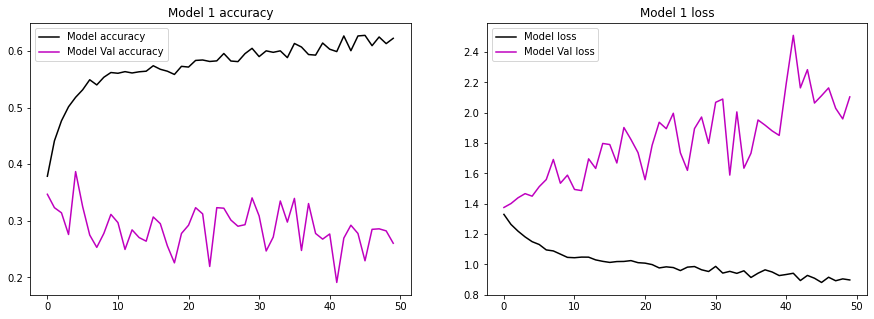

In [24]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [25]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [26]:
loss, acc = model.evaluate(xtrain_mocap_hand, ytrain_mocap_hand,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_hand, ytest_mocap_hand,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.97464 dan Training Accuracy 58.60%
Validation Loss 2.10432 dan Validation Accuracy 26.05%


In [27]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_hand)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_hand, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.74      0.47      0.57       933
         exc       0.95      0.33      0.49       742
         neu       0.74      0.46      0.57      1324
         sad       0.49      0.76      0.60       839

   micro avg       0.65      0.50      0.56      3838
   macro avg       0.73      0.50      0.55      3838
weighted avg       0.72      0.50      0.56      3838
 samples avg       0.50      0.50      0.50      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_hand)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_hand, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.22      0.44      0.29       170
         exc       0.07      0.01      0.02       299
         neu       0.34      0.43      0.38       384
         sad       0.00      0.00      0.00       245

   micro avg       0.28      0.22      0.25      1098
   macro avg       0.16      0.22      0.17      1098
weighted avg       0.17      0.22      0.18      1098
 samples avg       0.22      0.22      0.22      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


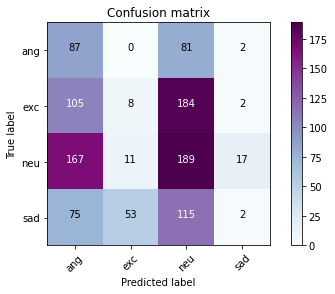

In [30]:
import itertools
Y_pred = model.predict(xtest_mocap_hand)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_hand,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**MODEL_HAND 3**

In [33]:
def gru_model_hand3():
    model = Sequential()
    
    model.add(Bidirectional(GRU(512, activation="relu", return_sequences=True), input_shape=(200, 18)))
    model.add(Bidirectional(GRU(256, activation='relu', return_sequences=True)))
    model.add(Bidirectional(GRU(128, activation='relu', return_sequences=False)))
  
    model.add(Dropout(0.1))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

    #print(model.summary())

    return model

In [34]:
model = gru_model_hand3()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 200, 1024)         1634304   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 512)          1969152   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               493056    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                

In [35]:
hist = model.fit(xtrain_mocap_hand, ytrain_mocap_hand, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_hand, ytest_mocap_hand))

Epoch 1/50
39/39 [==============================] - 77s 2s/step - loss: 14.4856 - accuracy: 0.2760 - val_loss: 1.4893 - val_accuracy: 0.3206
Epoch 2/50
39/39 [==============================] - 72s 2s/step - loss: 1.3009 - accuracy: 0.3817 - val_loss: 1.5310 - val_accuracy: 0.3033
Epoch 3/50
39/39 [==============================] - 72s 2s/step - loss: 1.1960 - accuracy: 0.4709 - val_loss: 1.5919 - val_accuracy: 0.2550
Epoch 4/50
39/39 [==============================] - 71s 2s/step - loss: 1.1619 - accuracy: 0.4742 - val_loss: 1.9231 - val_accuracy: 0.2741
Epoch 5/50
39/39 [==============================] - 71s 2s/step - loss: 1.1341 - accuracy: 0.5061 - val_loss: 1.7522 - val_accuracy: 0.2933
Epoch 6/50
39/39 [==============================] - 71s 2s/step - loss: 1.0998 - accuracy: 0.5117 - val_loss: 1.6721 - val_accuracy: 0.2377
Epoch 7/50
39/39 [==============================] - 72s 2s/step - loss: 1.0712 - accuracy: 0.5195 - val_loss: 1.6027 - val_accuracy: 0.2814
Epoch 8/50
39/39 [=

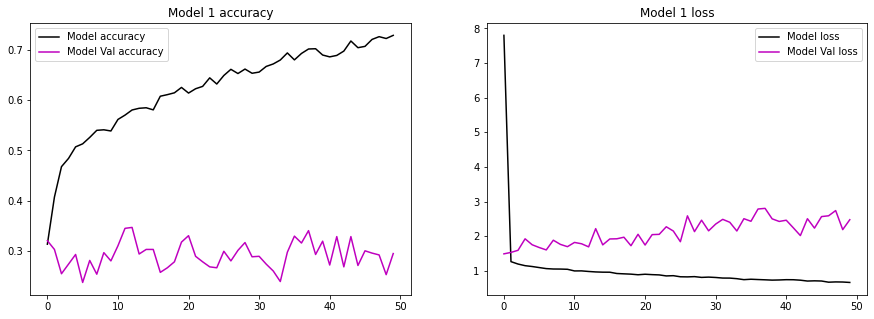

In [36]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [37]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [38]:
loss, acc = model.evaluate(xtrain_mocap_hand, ytrain_mocap_hand,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_hand, ytest_mocap_hand,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.61117 dan Training Accuracy 74.05%
Validation Loss 2.47472 dan Validation Accuracy 29.51%


In [39]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_hand)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_hand, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.76      0.69      0.73       933
         exc       0.85      0.61      0.71       742
         neu       0.80      0.64      0.71      1324
         sad       0.80      0.74      0.77       839

   micro avg       0.80      0.67      0.73      3838
   macro avg       0.81      0.67      0.73      3838
weighted avg       0.80      0.67      0.73      3838
 samples avg       0.67      0.67      0.67      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_hand)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_hand, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.24      0.22      0.23       170
         exc       0.10      0.04      0.06       299
         neu       0.36      0.56      0.43       384
         sad       0.09      0.01      0.01       245

   micro avg       0.30      0.24      0.27      1098
   macro avg       0.20      0.21      0.19      1098
weighted avg       0.21      0.24      0.21      1098
 samples avg       0.24      0.24      0.24      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


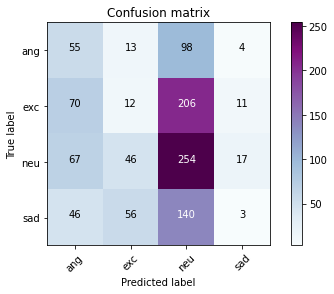

In [42]:
import itertools
Y_pred = model.predict(xtest_mocap_hand)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_hand,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**MODEL_HAND 4**

In [13]:
def gru_model_hand4():
    model = Sequential()
    
    model.add(Bidirectional(GRU(256, activation="relu", return_sequences=True), input_shape=(200, 18)))
    model.add(SeqSelfAttention(attention_activation="relu"))
    model.add(Bidirectional(GRU(256, activation='relu', return_sequences=True)))
    model.add(SeqSelfAttention(attention_activation="relu"))
    model.add(Bidirectional(GRU(128, activation='relu', return_sequences=False)))
   
    model.add(Dropout(0.1))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])


    #print(model.summary())

    return model

In [14]:
model = gru_model_hand4()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 200, 512)          423936    
_________________________________________________________________
seq_self_attention (SeqSelfA (None, None, 512)         32833     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 512)         1182720   
_________________________________________________________________
seq_self_attention_1 (SeqSel (None, None, 512)         32833     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               493056    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               6

In [15]:
hist = model.fit(xtrain_mocap_hand, ytrain_mocap_hand, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_hand, ytest_mocap_hand))

Epoch 1/50
39/39 [==============================] - 82s 2s/step - loss: 15.1248 - accuracy: 0.2923 - val_loss: 1.4932 - val_accuracy: 0.2149
Epoch 2/50
39/39 [==============================] - 74s 2s/step - loss: 1.2720 - accuracy: 0.4111 - val_loss: 1.5968 - val_accuracy: 0.2623
Epoch 3/50
39/39 [==============================] - 74s 2s/step - loss: 1.2119 - accuracy: 0.4535 - val_loss: 1.5692 - val_accuracy: 0.2851
Epoch 4/50
39/39 [==============================] - 75s 2s/step - loss: 1.1488 - accuracy: 0.4855 - val_loss: 1.7273 - val_accuracy: 0.3169
Epoch 5/50
39/39 [==============================] - 74s 2s/step - loss: 1.1379 - accuracy: 0.4925 - val_loss: 1.6938 - val_accuracy: 0.2541
Epoch 6/50
39/39 [==============================] - 74s 2s/step - loss: 1.0962 - accuracy: 0.5227 - val_loss: 1.7185 - val_accuracy: 0.2568
Epoch 7/50
39/39 [==============================] - 74s 2s/step - loss: 1.0735 - accuracy: 0.5356 - val_loss: 1.8243 - val_accuracy: 0.2814
Epoch 8/50
39/39 [=

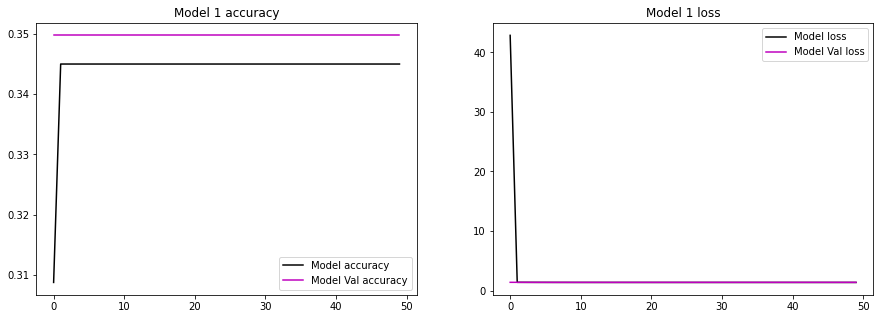

In [21]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [22]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [23]:
loss, acc = model.evaluate(xtrain_mocap_hand, ytrain_mocap_hand,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_hand, ytest_mocap_hand,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 1.36106 dan Training Accuracy 34.50%
Validation Loss 1.37772 dan Validation Accuracy 34.97%


In [24]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_hand)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_hand, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.00      0.00      0.00       933
         exc       0.00      0.00      0.00       742
         neu       0.00      0.00      0.00      1324
         sad       0.00      0.00      0.00       839

   micro avg       0.00      0.00      0.00      3838
   macro avg       0.00      0.00      0.00      3838
weighted avg       0.00      0.00      0.00      3838
 samples avg       0.00      0.00      0.00      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_hand)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_hand, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.00      0.00      0.00       170
         exc       0.00      0.00      0.00       299
         neu       0.00      0.00      0.00       384
         sad       0.00      0.00      0.00       245

   micro avg       0.00      0.00      0.00      1098
   macro avg       0.00      0.00      0.00      1098
weighted avg       0.00      0.00      0.00      1098
 samples avg       0.00      0.00      0.00      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


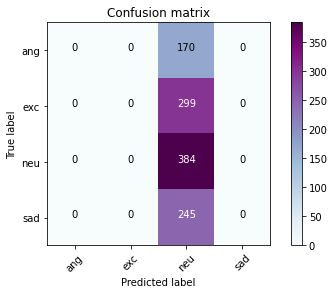

In [27]:
import itertools
Y_pred = model.predict(xtest_mocap_hand)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_hand,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

In [ ]:
mocap_rot = []

for ses_mod in data2:
    x_rot = ses_mod['mocap_rot']
    if(x_rot.shape != (200,165)):
        x_rot = np.zeros((200,165))  
    x_rot[np.isnan(x_rot)]=0
    mocap_rot.append( x_rot )
    
mocap_rot = np.array(mocap_rot)
mocap_rot.shape

In [ ]:
def lstm_model(optimizer='Adadelta'):
    model = Sequential()
    model.add(LSTM(512, return_sequences=True, input_shape=(200, 165)))
    model.add(LSTM(256, return_sequences=False))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
model = lstm_model()
model.summary()

hist = model.fit(mocap_rot, Y, 
                 batch_size=100, nb_epoch=3, verbose=1, shuffle = True, 
                 validation_split=0.2)

In [ ]:

hist = model.fit(mocap_rot, Y, 
                 batch_size=100, nb_epoch=3, verbose=1, shuffle = True, 
                 validation_split=0.2)

In [ ]:
def simple_conv(optimizer='Adam'):
    model = Sequential()
    model.add(Conv2D(32, 3, strides=(2, 2), border_mode='same', input_shape=(200, 165, 1)))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3, strides=(2, 2), border_mode='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3, strides=(2, 2), border_mode='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3, strides=(2, 2), border_mode='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3, strides=(2, 2), border_mode='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(Activation('relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
model = simple_conv()
model.summary()

mocap_rot_re = mocap_rot.reshape(-1,200,165,1)

hist = model.fit(mocap_rot_re, Y, 
                 batch_size=100, nb_epoch=2, verbose=1, shuffle = True, 
                 validation_split=0.2)

In [ ]:
def simple_conv2(optimizer='SGD'):
    model = Sequential()
    model.add(Conv2D(32, 3, strides=(2, 2), border_mode='same', input_shape=(200, 165, 1)))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3, strides=(2, 2), border_mode='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3, strides=(2, 2), border_mode='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3, strides=(2, 2), border_mode='same'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(Activation('relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
model = simple_conv2()
model.summary()

mocap_rot_re = mocap_rot.reshape(-1,200,165,1)

hist = model.fit(mocap_rot_re, Y, 
                 batch_size=100, nb_epoch=1, verbose=1, shuffle = True, 
                 validation_split=0.2)

In [ ]:
x_train_mocap = []
counter = 0
for ses_mod in data2:
    x_head = ses_mod['mocap_head']
    if(x_head.shape != (200,18)):
        x_head = np.zeros((200,18))   
    x_head[np.isnan(x_head)]=0
    x_hand = ses_mod['mocap_hand']
    if(x_hand.shape != (200,6)):
        x_hand = np.zeros((200,6))   
    x_hand[np.isnan(x_hand)]=0
    x_rot = ses_mod['mocap_rot']
    if(x_rot.shape != (200,165)):
        x_rot = np.zeros((200,165))   
    x_rot[np.isnan(x_rot)]=0
    x_mocap = np.concatenate((x_head, x_hand), axis=1)
    x_mocap = np.concatenate((x_mocap, x_rot), axis=1)
    x_train_mocap.append( x_mocap )
    
x_train_mocap = np.array(x_train_mocap)
x_train_mocap = x_train_mocap.reshape(-1,200,189,1)
x_train_mocap.shape

In [ ]:
def simple_conv3(optimizer='SGD'):
    model = Sequential()
    model.add(Conv2D(32, 3, strides=(2, 2), border_mode='same', input_shape=(200, 189, 1)))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3, strides=(2, 2), border_mode='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3, strides=(2, 2), border_mode='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3, strides=(2, 2), border_mode='same'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(Activation('relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
model = simple_conv3()
model.summary()


hist = model.fit(x_train_mocap, Y, 
                 batch_size=100, nb_epoch=1, verbose=1, shuffle = True, 
                 validation_split=0.2)

In [ ]:
model = AttentionResNet()